## Downloading data

In [ ]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
import torch
from torch import nn

import gdown
import zipfile
from pathlib import Path

## Args

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 15
learning_rate = 1e-3
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

In [ ]:
data_path = Path("data/")
image_path = data_path/ "food_dataset"

if image_path.is_dir():
  print(f'{image_path} already exists')
else:
  print(f'creating {image_path}')
  image_path.mkdir(parents=True, exist_ok=True)

gdown.download(id='1FADqhDJYCv6WkB-I4XsiAuq1L6ujDLpU', output="food_dataset.zip", quiet=False)

with zipfile.ZipFile("food_dataset.zip", "r") as zip_ref:
  print("Unziping data")
  zip_ref.extractall(image_path)

data/food_dataset already exists


Downloading...
From: https://drive.google.com/uc?id=1FADqhDJYCv6WkB-I4XsiAuq1L6ujDLpU
To: /content/food_dataset.zip
100%|██████████| 42.0M/42.0M [00:00<00:00, 242MB/s]


Unziping data


## Data preparation

In [ ]:
import os
def walk_through_dir(dir_path):
  """Walk through dir_path returning its contents"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dir_path}')

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/food_dataset
There are 4 directories and 0 images in data/food_dataset
There are 0 directories and 47 images in data/food_dataset
There are 0 directories and 46 images in data/food_dataset
There are 0 directories and 54 images in data/food_dataset
There are 0 directories and 53 images in data/food_dataset
There are 4 directories and 0 images in data/food_dataset
There are 0 directories and 151 images in data/food_dataset
There are 0 directories and 142 images in data/food_dataset
There are 0 directories and 163 images in data/food_dataset
There are 0 directories and 144 images in data/food_dataset


In [ ]:
train_dir = image_path/"train"
test_dir = image_path/"test"

## Visualizing image

Random image path: data/food_dataset/train/pho/471586.jpg
Image class: pho
Image height: 307
Image width: 512


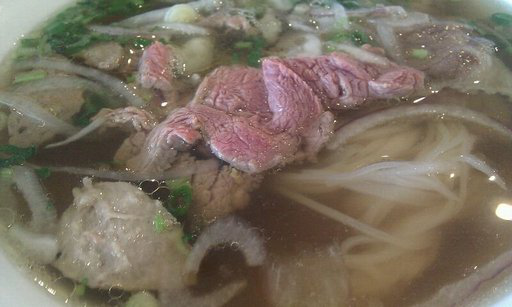

In [ ]:
import random
from PIL import Image


image_path_list = list(image_path.glob("*/*/*.jpg"))

random_img_path = random.choice(image_path_list)

img_class = random_img_path.parent.stem

img = Image.open(random_img_path)

print(f'Random image path: {random_img_path}')
print(f'Image class: {img_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')
img

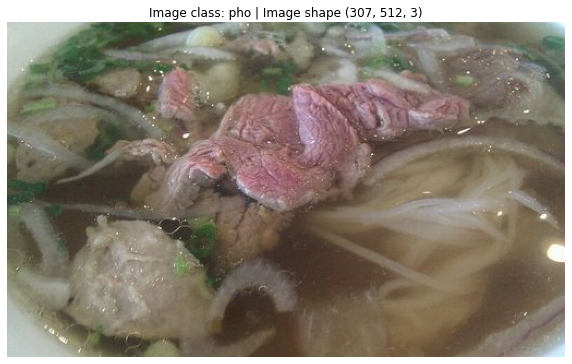

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {img_class} | Image shape {img_as_array.shape}")
plt.axis(False);

## Transforming data

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

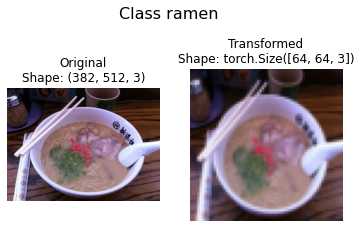

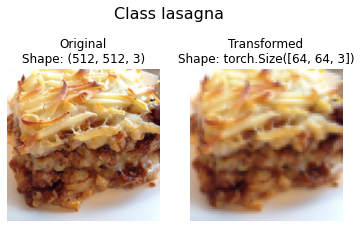

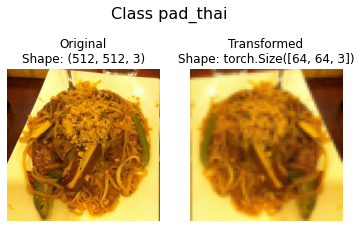

In [ ]:
def plot_transformed_images(image_path: list, transform, n=3):
  # if seed:
  #   random.seed(seed)

  random_image_paths = random.sample(image_path, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      img_array = np.asarray(f)
      ax[0].imshow(img_array)
      ax[0].set_title(f'Original\nShape: {img_array.shape}')
      ax[0].axis(False)

      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
      ax[1].axis(False)

      fig.suptitle(f"Class {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path=image_path_list,
                          transform = data_transform,
                          n=3)

## Loading image using `ImageFolder`

In [ ]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                 transform=data_transform,
                                 target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 600
     Root location: data/food_dataset/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 200
     Root location: data/food_dataset/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
class_names = train_data.classes
class_names

['lasagna', 'pad_thai', 'pho', 'ramen']

In [ ]:
class_dict = train_data.class_to_idx
class_dict

{'lasagna': 0, 'pad_thai': 1, 'pho': 2, 'ramen': 3}

In [ ]:
len(train_data), len(test_data)

(600, 200)

## DataLoader

In [ ]:
from torch.utils.data import DataLoader
import os
BATCH_SIZE = 1
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=False)

## Custom ImageFolder

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  classes = class_names_found = sorted([entry.name for entry in list(os.scandir(directory))])
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}")

  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [ ]:
class ImageFolderCustom(Dataset):
  def __init__(self,
               targ_dir: str,
               transform=None):
    self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg'))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_image(self, index: int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self) -> int:
    return len(self.paths)

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

## Data Augmentation

In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([
      transforms.Resize(size=(224,224)),
      transforms.TrivialAugmentWide(num_magnitude_bins=5),
      transforms.ToTensor()
])

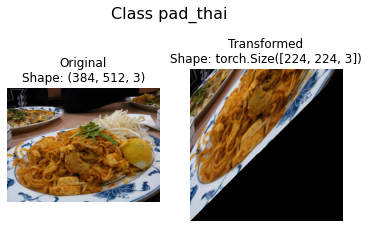

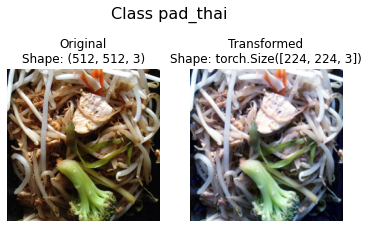

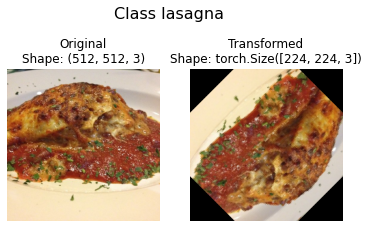

In [ ]:
image_path_list = list(image_path.glob('*/*/*.jpg'))

plot_transformed_images(image_path_list, transform=train_transform,n=3)

## Model 0: TinyVGG without data augmentation

In [ ]:
simple_transform = transforms.Compose([
      transforms.Resize(size=(64,64)),
      transforms.ToTensor()
])

In [ ]:
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                         transform=simple_transform)


NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple, 
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple, 
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

In [ ]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, 
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x

In [ ]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=4, bias=True)
  )
)

In [ ]:
img_batch, label_batch = next(iter(train_dataloader_simple))
img_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1,3,64,64])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 4]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## Train Step

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  model.train()

  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

## Test Step

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      test_loss += loss_fn(y_pred, y).item()
      y_pred_class = torch.softmax(y_pred, dim=1).argmax(dim=1)
      test_acc += (y_pred_class == y).sum().item() / len(y_pred)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc

## Train func

In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int=5,
          device = device):
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model,
                                       train_dataloader,
                                       loss_fn,
                                       optimizer,
                                       device)
    test_loss, test_acc = test_step(model,
                                       test_dataloader,
                                       loss_fn,
                                       device)
    
    print(f'Epoch: {epoch} | train loss: {train_loss: .4f} | train acc: {train_acc : .4f} | test loss: {test_loss: .4f} | test acc: {test_acc:.4f}')
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

  return results

## Train model_0

In [ ]:
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate)

from timeit import default_timer as timer
start_time = timer()
model_0_result = train(model=model_0,
                       train_dataloader=train_dataloader_simple,
                       test_dataloader=test_dataloader_simple,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=NUM_EPOCHS)
end_time = timer()

print(f'Total training time: {end_time - start_time:.3f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | train loss:  1.3865 | train acc:  0.2714 | test loss:  1.3783 | test acc: 0.2946
Epoch: 1 | train loss:  1.3764 | train acc:  0.2670 | test loss:  1.3599 | test acc: 0.2857
Epoch: 2 | train loss:  1.3181 | train acc:  0.3936 | test loss:  1.2330 | test acc: 0.4509
Epoch: 3 | train loss:  1.2471 | train acc:  0.4567 | test loss:  1.2092 | test acc: 0.4464
Epoch: 4 | train loss:  1.2389 | train acc:  0.4232 | test loss:  1.1836 | test acc: 0.4821
Epoch: 5 | train loss:  1.2191 | train acc:  0.4561 | test loss:  1.1813 | test acc: 0.4241
Epoch: 6 | train loss:  1.2012 | train acc:  0.4792 | test loss:  1.1793 | test acc: 0.4420
Epoch: 7 | train loss:  1.1937 | train acc:  0.4962 | test loss:  1.1784 | test acc: 0.4420
Epoch: 8 | train loss:  1.1699 | train acc:  0.4896 | test loss:  1.1491 | test acc: 0.5134
Epoch: 9 | train loss:  1.1668 | train acc:  0.4890 | test loss:  1.1592 | test acc: 0.3929
Total training time: 37.361 seconds


In [ ]:
model_0_result

{'train_loss': [1.3865436064569574,
  1.376355020623458,
  1.3180981999949406,
  1.247069001197815,
  1.2389106499521356,
  1.2190719340976917,
  1.2012307518406917,
  1.1936777453673513,
  1.169922897690221,
  1.16677126758977],
 'train_acc': [0.2713815789473684,
  0.26699561403508776,
  0.393640350877193,
  0.4566885964912281,
  0.4232456140350877,
  0.45614035087719296,
  0.47916666666666663,
  0.49616228070175444,
  0.48958333333333337,
  0.4890350877192982],
 'test_loss': [1.3782698597226823,
  1.3599234819412231,
  1.233003088406154,
  1.2092417308262415,
  1.183609928403582,
  1.1813390595572335,
  1.1793301616396223,
  1.1783503464290075,
  1.1490851640701294,
  1.1591680560793196],
 'test_acc': [0.29464285714285715,
  0.2857142857142857,
  0.45089285714285715,
  0.44642857142857145,
  0.48214285714285715,
  0.42410714285714285,
  0.4419642857142857,
  0.4419642857142857,
  0.5133928571428571,
  0.39285714285714285]}

## Plot loss curves

In [ ]:
from typing import Dict, List

def plot_loss_curves(result: Dict[str, List[float]]):
  epochs = range(len(result['train_loss']))

  plt.figure(figsize=(15,7))
  plt.subplot(1,2,1)
  plt.plot(epochs, result['train_loss'], label="train_loss")
  plt.plot(epochs, result['test_loss'], label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, result['train_acc'], label="train_acc")
  plt.plot(epochs, result['test_acc'], label="test_acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

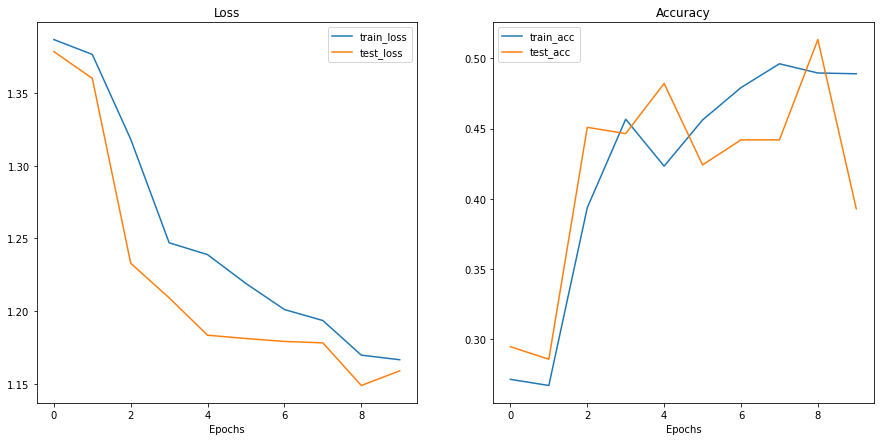

In [ ]:
plot_loss_curves(model_0_result)

## Model 1: TinyVGG with data augmentation

In [ ]:
from torchvision import transforms
train_transform_trivial = transforms.Compose([
                  transforms.Resize(size=(64,64)),
                  transforms.TrivialAugmentWide(num_magnitude_bins=10),
                  transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
                  transforms.Resize(size=(64,64)),
                  transforms.ToTensor()
])

In [ ]:
from torchvision import datasets
train_dataset = datasets.ImageFolder(root=train_dir,
                            transform=train_transform_trivial)
test_dataset = datasets.ImageFolder(root=test_dir,
                            transform=test_transform_simple)

In [ ]:
import os
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=False, 
                              num_workers=NUM_WORKERS)

In [ ]:
model_1 = TinyVGG(input_shape=3, hidden_units=15, output_shape=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)

from timeit import default_timer as timer
start_time = timer()

model_1_results = train(model_1,
                        train_dataloader,
                        test_dataloader,
                        optimizer,
                        loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

end_time = timer()

print(f'Total training time {end_time-start_time:.3f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | train loss:  1.3926 | train acc:  0.2429 | test loss:  1.3854 | test acc: 0.3059
Epoch: 1 | train loss:  1.3843 | train acc:  0.2769 | test loss:  1.3780 | test acc: 0.2697
Epoch: 2 | train loss:  1.3676 | train acc:  0.3191 | test loss:  1.3420 | test acc: 0.3849
Epoch: 3 | train loss:  1.3221 | train acc:  0.3575 | test loss:  1.2840 | test acc: 0.4276
Epoch: 4 | train loss:  1.3053 | train acc:  0.3843 | test loss:  1.2613 | test acc: 0.4008
Epoch: 5 | train loss:  1.2787 | train acc:  0.4183 | test loss:  1.2651 | test acc: 0.4622
Epoch: 6 | train loss:  1.2866 | train acc:  0.4062 | test loss:  1.2502 | test acc: 0.4413
Epoch: 7 | train loss:  1.2331 | train acc:  0.4359 | test loss:  1.2878 | test acc: 0.4156
Epoch: 8 | train loss:  1.2381 | train acc:  0.4726 | test loss:  1.2286 | test acc: 0.4474
Epoch: 9 | train loss:  1.2148 | train acc:  0.4616 | test loss:  1.2312 | test acc: 0.4578
Total training time 56.703 seconds


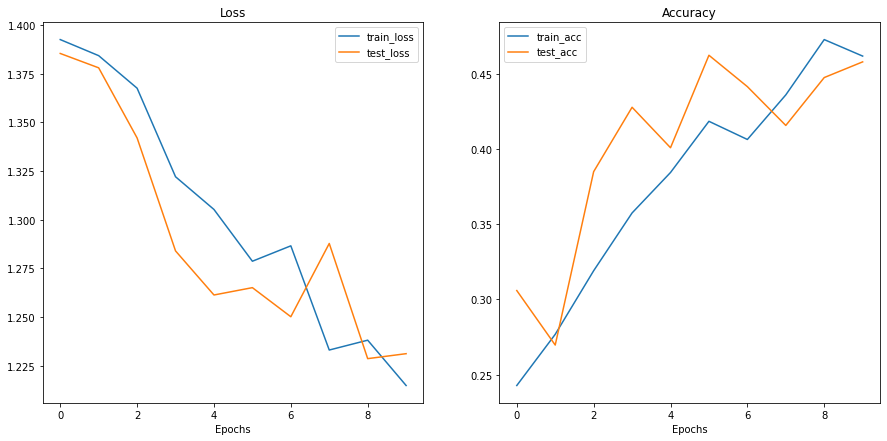

In [ ]:
plot_loss_curves(model_1_results)

## Predict

In [ ]:
!cp /content/data/food_dataset/test/pho/156053.jpg .

In [ ]:
import torchvision

def pred_image(model: torch.nn.Module,
               image_path: str,
               class_names: List[str] = None,
               transforms=None,
               device=device):
  
  custom_image_uint8 = torchvision.io.read_image(image_path).type(torch.float) / 255.
  if transforms:
    custom_image_uint8 = img_transform(custom_image_uint8)

  model.to(device)
  model.eval()
  with torch.inference_mode():
    pred = model(custom_image_uint8.unsqueeze(0).to(device))
    class_pred = torch.argmax(torch.softmax(pred, dim=1), dim=1)
    r = class_names[class_pred]
  return r

In [ ]:
img_transform = transforms.Compose([transforms.Resize(size=(64,64))])

In [ ]:
pred_image(model_1, str('156053.jpg'), class_names, img_transform, device)

'pho'

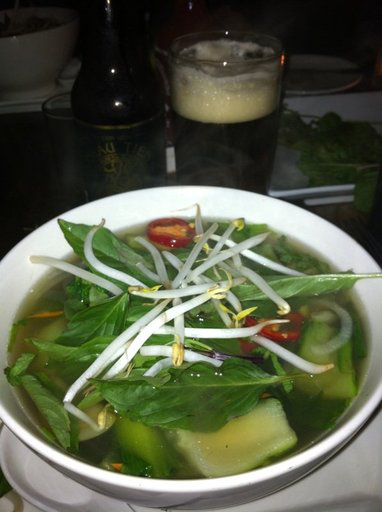

In [ ]:
Image.open("156053.jpg")

## Save model

In [ ]:
torch.save({'model_state_dict': model_1.state_dict(),
            }, 'classify_food.pt')

In [ ]:
!cp /content/classify_food.pt /content/drive/MyDrive